In [3]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from scipy.interpolate import splprep, splev
from scipy.optimize import curve_fit
from skimage import measure
import sympy as sp

# Cropping w ROI

In [ ]:
def draw_roi(event, x, y, flags, param):
    global roi_pts, drawing, completed

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        roi_pts = [(x, y)]

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        roi_pts.append((x, y))
        cv2.rectangle(image, roi_pts[0], roi_pts[1], (0, 255, 0), 2)
        cv2.imshow("Image", image)
        completed = True


# Load the image
image = cv2.imread(r'C:\Users\burka\Downloads\DSC_0448.jpg')

# Resize the image for better visibility if necessary
resize_factor = 0.5  # Adjust the value to resize the image
resized_image = cv2.resize(image, None, fx=resize_factor, fy=resize_factor)

# Create a window and set the callback function
cv2.namedWindow("Image")
cv2.setMouseCallback("Image", draw_roi)

# Variables to track ROI drawing
drawing = False
completed = False
roi_pts = []

# Display the resized image
cv2.imshow("Image", resized_image)

# Wait for the user to draw the ROI
while not completed:
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):  # Press 'q' to quit
        break

# Resize the ROI coordinates to match the original image size
if len(roi_pts) == 2:
    roi_pts = [(int(pt[0] / resize_factor), int(pt[1] / resize_factor)) for pt in roi_pts]

    # Crop the image based on the ROI
    roi = image[roi_pts[0][1]:roi_pts[1][1], roi_pts[0][0]:roi_pts[1][0]]
    cv2.imshow("Cropped ROI", roi)
    cv2.waitKey(0)

    # Save the cropped ROI image
    cv2.imwrite(r'C:\Users\burka\Downloads\DSC_0448_crop.png', roi)

# Clean up
cv2.destroyAllWindows()


# Image Scale_Pixel Conversion

In [4]:
## Image Scale - Pixel
image_path_0 = r'C:\Users\burka\Downloads\DSC_0448_scale.png'
img_0 = Image.open(image_path_0)
img_0 = img_0.convert("L")
img_array_0 = np.array(img_0)

img_blur_0 = cv2.GaussianBlur(img_array_0, (5, 5), 0)
_, binary_img_0 = cv2.threshold(img_blur_0, 120, 160, cv2.THRESH_BINARY_INV)#binarize image

np.shape(img_0)

conversion = np.shape(img_0)[0]
len_y = 3 * 11.31/7.67 #3mm und total höhe bild im PPTX ist 11.31cm/und 3mm Höhe ist 7.67
pixel_mm = conversion/len_y

pixel_mm = 196.6667 #From Image J 
#B1 = 198.6711 P/mm, B2 = 196.3379, Q3 = 196.6667, H2 = 216, H3 = 203.3336, H1 = 193.3333
print("Soviel Pixel entsprechen einem MM:",pixel_mm)

Soviel Pixel entsprechen einem MM: 196.6667


# Binarization

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


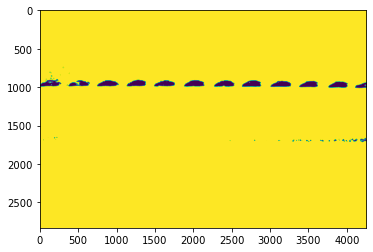

In [74]:
image_path = r'C:\Users\burka\Downloads\DotShapes\Homog1.jpg'
img = Image.open(image_path)
img = img.convert("L")
img_array = np.array(img)
img_blur = cv2.GaussianBlur(img_array, (5, 5), 0)

_, binary_img = cv2.threshold(img_blur, 130, 255, cv2.THRESH_BINARY_INV)#binarize image

plt.imshow(binary_img)
print(binary_img)


# Cropping to one Dot

(400, 400)

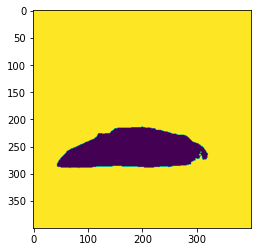

In [190]:
x1, y1 = 700, 700  # Top-left corner
x2, y2 = 1100, 1100  # Bottom-right corner

# Crop the binary image to the defined ROI
cropped_img = binary_img[y1:y2, x1:x2]

plt.imshow(cropped_img)


cropped_img.shape

# Contour Coordinates 

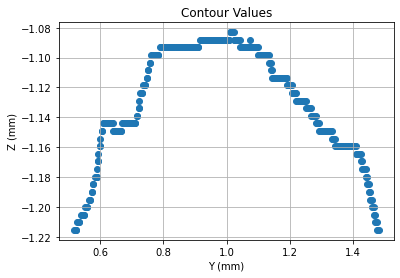

In [191]:
# Find the contours of the binary image
contours = measure.find_contours(cropped_img, 0.5)

# Extract the coordinates on the contour
contour_coordinates = []
for contour in contours:
    for point in contour:
        if point[0] < 240: ##Specific Code Y-AXIS To CUT
            x = int(point[1])
            y = int(point[0])
            contour_coordinates.append((x, y))

# Retrieve the x and y values
x_values = [coord[0] for coord in contour_coordinates]
y_values = [-coord[1] for coord in contour_coordinates]

coordinates = list(zip(x_values,y_values))
# Plot the graph


for i in range(len(x_values)):
    x_values[i] = x_values[i] / pixel_mm
    y_values[i] = y_values[i] / pixel_mm
    
plt.scatter(x_values, y_values, label='Data')
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.title('Contour Values')
plt.grid(True)
plt.show()



# Surface Ratio to Circle Paraboloid 

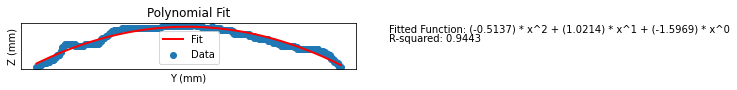

array([-0.51366251,  1.0214308 , -1.59687568])

<Figure size 432x288 with 0 Axes>

In [192]:
degree = 2  # Degree of the polynomial
coefficients = np.polyfit(x_values, y_values, degree)

# Generate x values for the fit
x_fit = np.linspace(min(x_values), max(x_values), 100)

# Evaluate the polynomial function for the fit
y_fit = np.polyval(coefficients, x_fit)
# Calculate the R-squared value
y_mean = np.mean(y_values)
ss_total = np.sum((y_values - y_mean)**2)
ss_residual = np.sum((y_values - np.polyval(coefficients, x_values))**2)
r2 = 1 - (ss_residual / ss_total)


# Create the polynomial equation string
equation_str = 'Fitted Function: '
for i, coeff in enumerate(coefficients[0:]):
    power = degree - i
    equation_str += f'({coeff:.4f}) * x^{power} + '
equation_str = equation_str[:-3]  # Remove the trailing '+ '

plt.scatter(x_values, y_values, label='Data')
# Plot the fitted polynomial function
plt.plot(x_fit, y_fit, 'r-', linewidth = 2,label='Fit')
plt.xlabel('Y (mm)')
plt.ylabel('Z (mm)')
plt.title('Polynomial Fit')
#plt.grid(True)
plt.legend()

# Display the R-squared value
plt.text(1.1, 0.8, equation_str, transform=plt.gca().transAxes)
plt.text(1.1, 0.60, f'R-squared: {r2:.4f}', transform=plt.gca().transAxes)
ax  = plt.gca()
ax.set_aspect('equal', adjustable='box')

ax.set_yticks(range(-10,0,50))
ax.set_xticks(range(0,10,50))
plt.show()

plt.savefig('parabolic.png')


data = np.column_stack((x_values, y_values))
np.savetxt('2D_Plot_Tanja_Half.csv', data, delimiter=',', header='Scatter_X,Scatter_Z', comments='')
coefficients



# Raw Data Assembly

In [218]:
##List w/ i1=c1,i2=b,i3=a
#Weighing Average

Averg_Homog = [[-1.5969,1.0214,-0.5137,0.9443],[-1.8348,1.3259,-0.5757,0.977],
                [-1.7954,1.2738,-0.5673,0.9573], [-2.0188,1.5643,-0.6853,0.8560], 
              [-1.7628,1.1528,-0.5645,0.9382],[-2.0334,1.2957,-0.6361,0.8855], 
              [-1.8828,1.2760,-0.5956,0.7955],[-1.6894,0.9787,-0.5576,0.8290]] 



Averg_Half = [[-1.7288, 2.1988,-1.0371,0.9826],[-1.7553,2.3145,-1.2145,0.9708], 
              [-2.3575,2.7406,-1.1483,0.9387], [-2.5643,3.5415,-1.7109,0.9547], 
              [-1.5510,1.8387,-1.2487, 0.977],[-1.5139,1.4278,-0.9772,0.9523], 
              [-1.8711,1.8365,-0.9855,0.9639],[-1.7134,1.7589,-1.1103,0.9475], 
              [-2.486,2.636,-1.1623,0.9687],[-1.9807,1.8247,-0.9122,0.8606]] 


Averg_Quarter = [[-1.8568,1.7313,-0.8076,0.9707],[-1.6177,1.4586,-0.8123,0.9436], 
              [-2.0329,1.8245,-0.8107,0.9664], [-1.7790,1.4795,-0.7834,0.9705], 
              [-2.935,2.2867,-0.7373,0.9355],[-1.2648,1.1739,-0.8121,0.5892], 
              [-1.724,1.9095,-0.9762,0.9749],[-1.5918, 1.7095, -0.9887, 0.9812], 
              [-1.9642, 1.9353, -0.8240, 0.9883],[-2.3091,2.0350,-0.7356,0.9443]] 


Averg_Bulk = [[-1.5939,1.0967,-0.5059,0.9722],[-1.4052, 0.8297, -0.4706,0.9239], 
              [-1.6329,1.1106,-0.5208,0.9464], [-1.4429, 0.8350,-0.4773,0.9602], 
              [-1.5407,0.9171,-0.5009,0.9506],[-1.4835, 0.8735, -0.4826, 0.9649], 
              [-1.4937,0.8767,-0.5345,0.9681],[-1.6295,0.9698,-0.5020,0.9613], 
              [-1.5155, 0.93,-0.5554, 0.9512],[-1.7178,1.0975,-0.5328,0.9725]] 
#Bulk1 [i = Dot1, a,b,c,R2] #always take 5 dots per sample and 2 samples (limit quarter)

# Separate the coefficients and R^2 values
fit_coeff = np.array([entry[:3] for entry in Averg_Bulk])
r_values = np.array([entry[3] for entry in Averg_Bulk])

weights = np.sqrt(r_values)
average_coefficients = np.average(fit_coeff, axis=0, weights=weights) ## Compute the weighted average of the coefficients

print(f"Weighted average fit Bulk: c = {round(average_coefficients[0],2)}, b = {round(average_coefficients[1],2)}, a = {round(average_coefficients[2],2)}")


Weighted average fit Bulk: c = -1.55, b = 0.95, a = -0.51


# Avg_Radius from Top-View

In [302]:
# From TopView Data Points evaluated w/ ImageJ - Avg 
# Radius = Bulk, Half, Quarter, Homog
Radius = [1.604/2, 1.365/2, 1.461/2, 1.575/2]

print(1.365/2)
print(1.604/2)

0.6825
0.802


# Coefficients

In [296]:
coeff_bulk = [-1.55,0.95,-0.51]
coeff_bulk = coeff_bulk[::-1]
coeff_half = [-1.95,2.21,-1.15]
coeff_half = coeff_half[::-1]
coeff_quarter = [-1.92,1.77,-0.83]
coeff_quarter = coeff_quarter[::-1]
coeff_homog = [-1.83,1.24,-0.59]
coeff_homog = coeff_homog[::-1]

coeff = [coeff_bulk,coeff_half,coeff_quarter,coeff_homog]

# Vertex Coordinates

In [297]:
def find_vertex(a, b, c):
    h = -b / (2*a)
    k = a*h**2 + b*h + c
    return (h, k)


def y_radius(r,vertex_x,a,b,c):
    x = vertex_x-r
    y = a*x**2 + b*x + c
    return y

# coefficients
height = []
center = [[] for i in range(4)]

for i in range(4):
    vertex = find_vertex(coeff[i][0],coeff[i][1], coeff[i][2])
    y_0 = y_radius(Radius[i],vertex[0],coeff[i][0],coeff[i][1], coeff[i][2])
    height_tmp = vertex[1] - y_0
    height.append(height_tmp)
    center[i].append([vertex[0],y_0])

height

[0.32803404000000014,
 0.5356771875000002,
 0.4429131074999999,
 0.3658921875000001]

# Visualisation

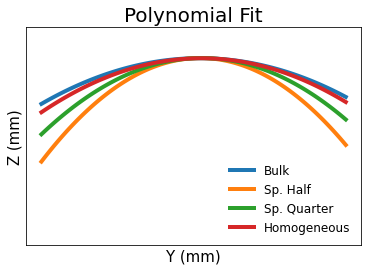

In [298]:
x = np.linspace(-10,11,100)
coeff_l = ['Bulk','Sp. Half','Sp. Quarter','Homogeneous']

def f(x,a,b,c):
    return a*x**2 + b*x + c

for i in range(4):
    y = f(x,coeff[i][0],coeff[i][1],coeff[i][2])
    plt.plot(x,y,linewidth = 4,label= coeff_l[i])
    
plt.xlabel('Y (mm)',fontsize = 15)
plt.ylabel('Z (mm)', fontsize = 15)
plt.title('Polynomial Fit',fontsize = 20)
plt.legend(frameon = False, fontsize = 12)
plt.ylim(-250,40)
plt.xticks([])
plt.yticks([])

plt.show()
plt.show()

# Conversion-Factor for Surface_Calculation

In [306]:
#This factor is implemented in Surface_Calculation
height

import math
def calculate_surface(r, h): #source = https://www.had2know.org/academics/paraboloid-surface-area-volume-calculator.html
    numerator = (r**2 + 4*h**2)**(3/2) - r**3
    denominator = 6 * h**2
    surface = (math.pi * r) * numerator / denominator
    return surface


surface_area = []
surf_dot = []
number_dots = [184,92,46,184]
conver_factor = []
for i in range(len(height)):
    r = Radius[i]
    surface_ = calculate_surface(r,height[i])
    surf_dot.append(surface_)
    conver_factor.append(surface_/(math.pi * r**2))
    #SA = (π/6)(r/h²)[(r² + 4h²)3/2 - r³] 
    surface_area.append(surface_*number_dots[i])
    

surf_dot

[2.328201976525268, 2.1567348848658576, 2.191241748411626, 2.322240438286169]

# Stimulus Size

In [300]:
#Stimulus Size
concentrations = [0,0.18,0.36,0.09]
stimulus_size = []
for i in range(4):
    size_tmp = concentrations[i]*surface_area[i]
    print("Stimulus Size of",coeff_l[i],"is",size_tmp,"mm2*wt%")
    stimulus_size.append(size_tmp)

Stimulus Size of Bulk is 0.0 mm2*wt%
Stimulus Size of Sp. Half is 35.7155296933786 mm2*wt%
Stimulus Size of Sp. Quarter is 36.28696335369652 mm2*wt%
Stimulus Size of Homogeneous is 38.45630165801895 mm2*wt%


# Generate the adapted Surface Function

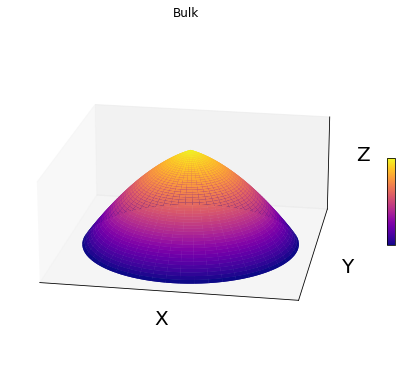

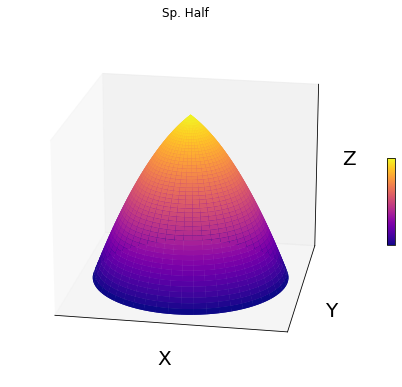

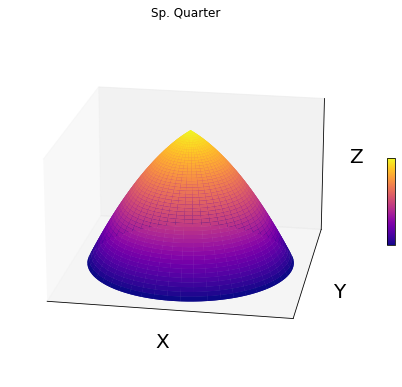

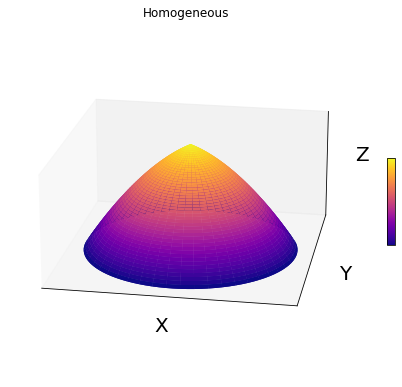

In [301]:
save = False

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters for the circular base (xy-plane)
#radius = 0.5*(max(x_values)-min(x_values))  # Radius of the circular base
 ###INPUT REAL VALUE FROM FIJI
title = coeff_l

for i in range(4):
    radius,Height = Radius[i],height[i]
    center_ = (center[i][0][0],center[i][0][1])  # Center coordinates of the circular base

    coefficients_ = [coeff[i][0],coeff[i][1],coeff[i][2]]
    # Generate mesh grid of x, y, and z values

    theta = np.linspace(0, 2 * np.pi, 100)
    z = np.linspace(-2, 0, 100)

    theta_mesh, z_mesh = np.meshgrid(theta, z)

    x_mesh = center_[0] + radius * z_mesh * np.cos(theta_mesh)
    y_mesh = center_[1] + radius * z_mesh * np.sin(theta_mesh)
    z_poly_mesh = np.polyval(coefficients_, z_mesh)

    # Plot the paraboloid surface
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x_mesh, y_mesh, z_poly_mesh, cmap ='plasma') #color='blue'cmap='plasma'
    #fig.colorbar(ax.plot_surface(x_mesh, y_mesh, z_poly_mesh, cmap ='plasma'), shrink=0.2, aspect=4, use_gridspec=False)

    # Set plot labels and title
    ax.set_xlabel('X', fontsize = 20)
    ax.set_ylabel('Y', fontsize = 20)
    ax.set_zlabel('Z', fontsize = 20)
    ax.set_title(title[i])

    # Remove grid and ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    # Change perspective
    ax.view_init(elev=20, azim=-80)

    #ax.set_box_aspect([1, 1, y_delta/x_delta])
    ax.set_box_aspect([1, 1, Height/radius])
    # Manually define the ticks and labels
    cbar = fig.colorbar(ax.plot_surface(x_mesh, y_mesh, z_poly_mesh, cmap ='plasma'), shrink=0.2, aspect=10)

    cbar.set_ticks([2, 4, 6, 8, 10])
    #cbar.set_ticklabels(['0', '0.25R ', '0.6R ', 'R', ' ', ' ', 'High'])


plt.show()

x, y, z = sp.symbols('x y z')

# Define the equations for the circular base and the polynomial function
circle_equation = x**2 + y**2 - radius**2

# Save the data to a CSV file

data = np.column_stack((x_mesh.flatten(), y_mesh.flatten(), z_poly_mesh.flatten()))
np.savetxt('paraboloid_data.csv', data, delimiter=',', header='X,Y,Z', comments='')

# Save the figure as an image
if save == True:
    fig.savefig('paraboloid.png')

# Convert the image to STL format
#mesh = pv.read('paraboloid.png')
#mesh.save('paraboloid.stl')

# Show the figure
#plt.show()